Epoch 1/30 — F1 train: 0.0388 | F1 val: 0.0335
Epoch 2/30 — F1 train: 0.0859 | F1 val: 0.0948
Epoch 3/30 — F1 train: 0.1178 | F1 val: 0.0864
Epoch 4/30 — F1 train: 0.1364 | F1 val: 0.1066
Epoch 5/30 — F1 train: 0.1852 | F1 val: 0.1717
Epoch 6/30 — F1 train: 0.2286 | F1 val: 0.2004
Epoch 7/30 — F1 train: 0.2761 | F1 val: 0.2450
Epoch 8/30 — F1 train: 0.3174 | F1 val: 0.2783
Epoch 9/30 — F1 train: 0.3534 | F1 val: 0.2950
Epoch 10/30 — F1 train: 0.4155 | F1 val: 0.3551
Epoch 11/30 — F1 train: 0.4418 | F1 val: 0.3743
Epoch 12/30 — F1 train: 0.4674 | F1 val: 0.3971
Epoch 13/30 — F1 train: 0.4939 | F1 val: 0.4082
Epoch 14/30 — F1 train: 0.5279 | F1 val: 0.4455
Epoch 15/30 — F1 train: 0.5712 | F1 val: 0.4711
Epoch 16/30 — F1 train: 0.5859 | F1 val: 0.4844
Epoch 17/30 — F1 train: 0.6056 | F1 val: 0.5029
Epoch 18/30 — F1 train: 0.6378 | F1 val: 0.5154
Epoch 19/30 — F1 train: 0.6482 | F1 val: 0.5435
Epoch 20/30 — F1 train: 0.6990 | F1 val: 0.5857
Epoch 21/30 — F1 train: 0.7014 | F1 val: 0.5747
E

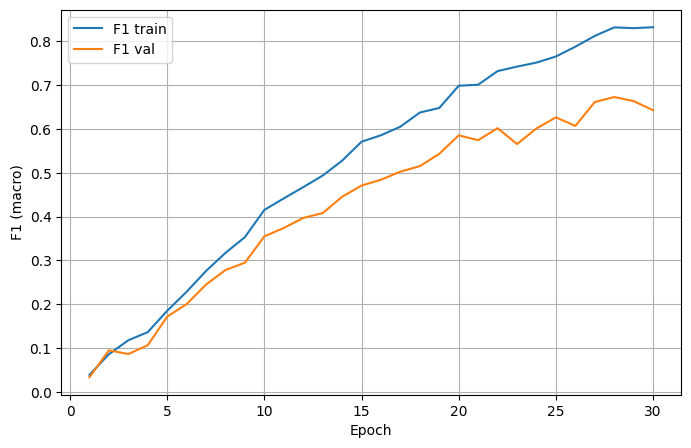

Best validation F1: 0.6732


In [10]:
import re, os
from collections import Counter
from statistics import mean
from itertools import islice
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt

# -----------------------------
# UTIL
# -----------------------------
pattern_ecran = re.compile(r"\((.*?)\)")
pattern_conf = re.compile(r"<(.*?)>")
pattern_chaine = re.compile(r"\$(.*?)\$")

def read_ds(filename: str, has_label: bool = True):
    """Read CSV-like file into DataFrame."""
    if not os.path.exists(filename):
        raise FileNotFoundError(f"{filename} not found")
    rows = []
    with open(filename, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line: continue
            if (line.startswith('"') and line.endswith('"')) or (line.startswith("'") and line.endswith("'")):
                line = line[1:-1]
            parts = line.split(',')
            if has_label:
                util, navigateur, actions = parts[0], parts[1] if len(parts)>1 else "", parts[2:]
            else:
                util, navigateur, actions = None, parts[0] if len(parts)>1 else "", parts[1:] if len(parts)>1 else parts
            rows.append({"util": util, "navigateur": navigateur, "parts": actions})
    return pd.DataFrame(rows)

def filter_action(value: str):
    if not isinstance(value, str): return ""
    if value.startswith("t") and value[1:].isdigit(): return ""
    for delim in ["(", "<", "$", "1"]:
        if delim in value:
            idx = value.find(delim)
            if idx > 0: value = value[:idx]
    return value.strip()

def ngrams(lst, n):
    return zip(*(islice(lst, i, None) for i in range(n)))

def extract_features_from_parts(parts, top_action_set=None, top_bigram_set=None):
    feats = {}
    actions_raw = [p for p in parts if isinstance(p,str)]
    t_marks, actions = [], []
    for a in actions_raw:
        a_strip = a.strip()
        if a_strip.startswith("t") and a_strip[1:].isdigit(): t_marks.append(int(a_strip[1:]))
        else:
            a_clean = filter_action(a_strip)
            if a_clean: actions.append(a_clean)

    feats["n_actions"] = len(actions)
    feats["n_unique_actions"] = len(set(actions))
    feats["repeat_ratio"] = 1.0 - (feats["n_unique_actions"]/feats["n_actions"]) if feats["n_actions"]>0 else 0.0
    feats["n_modif"] = sum(1 for r in actions_raw if isinstance(r,str) and r.strip().endswith("1"))
    feats["modif_ratio"] = feats["n_modif"]/feats["n_actions"] if feats["n_actions"]>0 else 0.0
    feats["t_count"] = len(t_marks)
    feats["max_time"] = max(t_marks) if t_marks else 0
    feats["avg_time_gap"] = mean([j-i for i,j in zip(t_marks[:-1], t_marks[1:])]) if len(t_marks)>1 else 0.0
    feats["tempo_density"] = feats["n_actions"] / (feats["max_time"]+1) if feats["max_time"]>=0 else 0.0

    # action counts
    a_counts = Counter(actions)
    if top_action_set is not None:
        for act in top_action_set: feats[f"act_{act}"] = a_counts.get(act,0)
    else:
        for act,cnt in a_counts.items(): feats[f"act_{act}"] = cnt

    # bigram counts
    bigrams = ["_".join(bg) for bg in ngrams(actions, 2)]
    b_counts = Counter(bigrams)
    if top_bigram_set is not None:
        for bg in top_bigram_set: feats[f"bigram_{bg}"] = b_counts.get(bg,0)
    else:
        for bg,cnt in b_counts.items(): feats[f"bigram_{bg}"] = cnt

    # longest consecutive repeat
    longest_repeat = 0
    if actions:
        cur = 1
        for i in range(1, len(actions)):
            if actions[i]==actions[i-1]: cur+=1
            else: longest_repeat=max(longest_repeat,cur); cur=1
        longest_repeat=max(longest_repeat,cur)
    feats["longest_repeat"] = longest_repeat

    feats["unique_transitions"] = len(set(bigrams))
    feats["actions_joined"] = " ".join([a.replace(" ", "_") for a in actions])
    return feats

# -----------------------------
# MAIN PIPELINE
# -----------------------------
def main_lstm_f1(config):
    train_raw = read_ds(config["train_file"], has_label=True)
    test_raw  = read_ds(config["test_file"],  has_label=False)

    # compute top actions/bigrams
    all_actions, all_bigrams = [], []
    for _, r in train_raw.iterrows():
        parts = [p for p in r["parts"] if isinstance(p,str)]
        actions = [filter_action(p.strip()) for p in parts if not (p.strip().startswith("t") and p.strip()[1:].isdigit()) and filter_action(p.strip())]
        all_actions.extend(actions)
        all_bigrams.extend(["_".join(bg) for bg in ngrams(actions, 2)])
    top_actions = [a for a,_ in Counter(all_actions).most_common(config["top_k_actions"])]
    top_bigrams = [b for b,_ in Counter(all_bigrams).most_common(config["top_k_bigrams"])]
    top_action_set, top_bigram_set = set(top_actions), set(top_bigrams)

    # extract tabular features
    df_train_feats = pd.DataFrame([extract_features_from_parts(r["parts"], top_action_set, top_bigram_set) | {"navigateur": r["navigateur"], "util": r["util"]} for _, r in train_raw.iterrows()]).fillna(0)
    df_test_feats  = pd.DataFrame([extract_features_from_parts(r["parts"], top_action_set, top_bigram_set) | {"navigateur": r["navigateur"]} for _, r in test_raw.iterrows()]).fillna(0)

    # tokenizer
    tokenizer = Tokenizer(oov_token="<UNK>")
    tokenizer.fit_on_texts(df_train_feats["actions_joined"].tolist())
    vocab_size = len(tokenizer.word_index)+1
    X_seq_train = pad_sequences(tokenizer.texts_to_sequences(df_train_feats["actions_joined"].tolist()), maxlen=500, padding='post')
    X_seq_test  = pad_sequences(tokenizer.texts_to_sequences(df_test_feats["actions_joined"].tolist()), maxlen=500, padding='post')

    # numeric tabular
    exclude_cols = {"actions_joined","util","navigateur"}
    numeric_cols = [c for c in df_train_feats.columns if c not in exclude_cols and df_train_feats[c].dtype in [np.float64,np.int64,np.int32,np.float32,np.int16]]
    scaler = StandardScaler()
    X_tab_train = scaler.fit_transform(df_train_feats[numeric_cols].values)
    X_tab_test  = scaler.transform(df_test_feats[numeric_cols].values)

    # browser encoding
    try:
        ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
    except TypeError:
        ohe = OneHotEncoder(sparse=False, handle_unknown="ignore")
    ohe.fit(df_train_feats[["navigateur"]].fillna("UNK"))
    X_nav_train = ohe.transform(df_train_feats[["navigateur"]].fillna("UNK"))
    X_nav_test  = ohe.transform(df_test_feats[["navigateur"]].fillna("UNK"))

    X_tab_train_full = np.hstack([X_tab_train, X_nav_train])
    X_tab_test_full  = np.hstack([X_tab_test, X_nav_test])

    # labels
    label_encoder = LabelEncoder()
    y_train = label_encoder.fit_transform(df_train_feats["util"].astype(str))
    n_classes = len(label_encoder.classes_)

    # train/val split
    X_seq_tr, X_seq_val, X_tab_tr, X_tab_val, y_tr, y_val = train_test_split(
        X_seq_train, X_tab_train_full, y_train,
        test_size=config["test_size"], stratify=y_train, random_state=config["random_state"]
    )

    # build model
    tf.keras.backend.clear_session()
    seq_input = Input(shape=(X_seq_tr.shape[1],))
    x_seq = Embedding(vocab_size, config["embedding_dim"])(seq_input)
    x_seq = LSTM(config["lstm_units"])(x_seq)
    x_seq = Dropout(config["dropout_rate"])(x_seq)
    tab_input = Input(shape=(X_tab_tr.shape[1],))
    x_tab = Dense(config["dense_units_tabular"][0], activation="relu")(tab_input)
    x_tab = Dropout(config["dropout_rate"])(x_tab)
    x = Concatenate()([x_seq, x_tab])
    for units in config["dense_units_after_concat"]:
        x = Dense(units, activation="tanh")(x)
        x = Dropout(config["dropout_rate"])(x)
    out = Dense(n_classes, activation="softmax")(x)
    model = Model([seq_input, tab_input], out)
    model.compile(optimizer=config["optimizer"], loss=config["loss"])

    # training + F1 tracking
    f1_tr_list, f1_val_list = [], []
    best_f1_val = 0.0
    for epoch in range(config["epochs"]):
        model.fit([X_seq_tr, X_tab_tr], tf.keras.utils.to_categorical(y_tr, n_classes),
                  validation_data=([X_seq_val, X_tab_val], tf.keras.utils.to_categorical(y_val, n_classes)),
                  epochs=1, batch_size=config["batch_size"], verbose=0)
        y_pred_val = np.argmax(model.predict([X_seq_val, X_tab_val], verbose=0), axis=1)
        y_pred_tr  = np.argmax(model.predict([X_seq_tr, X_tab_tr], verbose=0), axis=1)
        f1_val = f1_score(y_val, y_pred_val, average='macro', zero_division=0)
        f1_tr  = f1_score(y_tr, y_pred_tr, average='macro', zero_division=0)
        f1_tr_list.append(f1_tr)
        f1_val_list.append(f1_val)
        if f1_val > best_f1_val: best_f1_val = f1_val
        print(f"Epoch {epoch+1}/{config['epochs']} — F1 train: {f1_tr:.4f} | F1 val: {f1_val:.4f}")

    # plot
    plt.figure(figsize=(8,5))
    plt.plot(range(1, config["epochs"]+1), f1_tr_list, label="F1 train")
    plt.plot(range(1, config["epochs"]+1), f1_val_list, label="F1 val")
    plt.xlabel("Epoch"); plt.ylabel("F1 (macro)"); plt.grid(True); plt.legend(); plt.show()

    print(f"Best validation F1: {best_f1_val:.4f}")
    return f1_tr_list, f1_val_list, best_f1_val

# -----------------------------
# RUN
# -----------------------------
CONFIG = {
    "embedding_dim": 64, "lstm_units": 128, "dense_units_after_concat":[256,128,64],
    "dense_units_tabular":[128], "dropout_rate":0.3,
    "epochs":30, "batch_size":64, "optimizer":"adam", "loss":"categorical_crossentropy",
    "test_size":0.1, "random_state":42,
    "top_k_actions":200, "top_k_bigrams":200,
    "train_file":"train.csv", "test_file":"test.csv"
}

if __name__ == "__main__":
    f1_tr, f1_val, best_f1 = main_lstm_f1(CONFIG)
